Fuente de Datos : https://www.kaggle.com/kyanyoga/sample-sales-data

# IMPORTAR LIBRERÍAS Y DATASETS

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go

from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline

In [ ]:
# Procedemos a montar el disco usando los siguientes comandos:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sales_df = pd.read_csv('/content/drive/MyDrive/01_Oriol/01_Machine Learning/07_Masterclass-IA-Moderna/03_Marketing/sales_data_sample.csv', encoding = 'unicode_escape')

In [ ]:
sales_df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,Ships,54,S72_3212,Euro Shopping Channel,(91) 555 94 44,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,100.00,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,Ships,54,S72_3212,"Oulu Toy Supplies, Inc.",981-443655,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium
2820,10386,43,100.00,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,Ships,54,S72_3212,Euro Shopping Channel,(91) 555 94 44,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,Ships,54,S72_3212,Alpha Cognac,61.77.6555,1 rue Alsace-Lorraine,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small


In [ ]:
# Veamos los tipos de datos
sales_df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [ ]:
# Convertir la fecha del pedido en formato de fecha y hora
sales_df['ORDERDATE'] = pd.to_datetime(sales_df['ORDERDATE'])
# Comprobar el tipo de datos
sales_df.dtypes

ORDERNUMBER                  int64
QUANTITYORDERED              int64
PRICEEACH                  float64
ORDERLINENUMBER              int64
SALES                      float64
ORDERDATE           datetime64[ns]
STATUS                      object
QTR_ID                       int64
MONTH_ID                     int64
YEAR_ID                      int64
PRODUCTLINE                 object
MSRP                         int64
PRODUCTCODE                 object
CUSTOMERNAME                object
PHONE                       object
ADDRESSLINE1                object
ADDRESSLINE2                object
CITY                        object
STATE                       object
POSTALCODE                  object
COUNTRY                     object
TERRITORY                   object
CONTACTLASTNAME             object
CONTACTFIRSTNAME            object
DEALSIZE                    object
dtype: object

In [ ]:
# Comprobar el número de elementos no nulos del data frame
sales_df.info()

# Comprobar el número de elementos nulos del data frame
sales_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [ ]:
# Dado que hay muchos valores nulos en 'addressline2', 'state', 'postal code' y 'territorio', podemos eliminarlos.
# Country representaría la información geográfica del pedido.
# También podemos eliminar la ciudad, la dirección1, el número de teléfono, el nombre del contacto, el apellido del contacto y el nombre del contacto, ya que no son necesarios para el análisis.

df_drop  = ['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df = sales_df.drop(df_drop, axis = 1)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,USA,Medium


In [ ]:
sales_df.isnull().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

In [ ]:
# Obtener las observaciones únicas de cada columna
sales_df.nunique()

QUANTITYORDERED      58
PRICEEACH          1016
ORDERLINENUMBER      18
SALES              2763
ORDERDATE           252
STATUS                6
QTR_ID                4
MONTH_ID             12
YEAR_ID               3
PRODUCTLINE           7
MSRP                 80
PRODUCTCODE         109
COUNTRY              19
DEALSIZE              3
dtype: int64

# ANALISIS EXPLORATORIO DE LOS DATOS Y LIMPIEZA

In [ ]:
sales_df['COUNTRY'].value_counts().index

Index(['USA', 'Spain', 'France', 'Australia', 'UK', 'Italy', 'Finland',
       'Norway', 'Singapore', 'Canada', 'Denmark', 'Germany', 'Sweden',
       'Austria', 'Japan', 'Belgium', 'Switzerland', 'Philippines', 'Ireland'],
      dtype='object')

In [ ]:
sales_df['COUNTRY'].value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

In [ ]:
# Visualizar el recuento de elementos en una columna determinada

def barplot_visualization(x):
  fig = plt.Figure(figsize = (12, 6))
  fig = px.bar(x = sales_df[x].value_counts().index, y = sales_df[x].value_counts(), color = sales_df[x].value_counts().index, height = 600)
  fig.show()

In [ ]:
# Llamamos a esta función para cualquier columna determinada, como 'COUNTRY'
barplot_visualization('COUNTRY')

In [ ]:
barplot_visualization('STATUS')

In [ ]:
sales_df.drop(columns= ['STATUS'], inplace = True)
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,USA,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Spain,Small
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Finland,Medium
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Spain,Medium
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,France,Small


In [ ]:
barplot_visualization('PRODUCTLINE')

In [ ]:
barplot_visualization('DEALSIZE')

In [ ]:
# Agregar variables ficticias para reemplazar variables categóricas

def dummies(x):
  dummy = pd.get_dummies(sales_df[x])
  sales_df.drop(columns = x , inplace = True)
  return pd.concat([sales_df, dummy], axis = 1)

In [ ]:
# Obtenemos variables ficticias para la columna 'PAÍS'
sales_df = dummies('COUNTRY')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,DEALSIZE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Medium,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sales_df = dummies('PRODUCTLINE')

In [ ]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,DEALSIZE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,Medium,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,Medium,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
sales_df = dummies('DEALSIZE')
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,S72_3212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,S72_3212,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,S72_3212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,S72_3212,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
y = pd.Categorical(sales_df['PRODUCTCODE'])
y

['S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', 'S10_1678', ..., 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212', 'S72_3212']
Length: 2823
Categories (109, object): ['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', ..., 'S700_3962',
                           'S700_4002', 'S72_1253', 'S72_3212']

In [ ]:
y = pd.Categorical(sales_df['PRODUCTCODE']).codes
y

array([  0,   0,   0, ..., 108, 108, 108], dtype=int8)

In [ ]:
# Dado que el número de código de producto tiene 109 valores únicos, si agregamos variables one-hot,
# serían 109 columnas adicionales, podemos evitarlo usando la codificación categórica

sales_df['PRODUCTCODE'] = pd.Categorical(sales_df['PRODUCTCODE']).codes

In [ ]:
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,54,108,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,54,108,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
# Agrupamos los datos según la fecha del pedido
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
ORDERDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,4,0,2,2
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181.0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,2
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,1,1
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723.0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,3,0,0,0,0,7,6,0,10,6
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,7,0,0,0,2,4,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,6,0,0,0,0,0,2,3,1
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462.0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,2,8,4
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,0,0,0,0,0,8,0,8,7


In [ ]:
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()

In [ ]:
# Podemos eliminar 'ORDERDATE' y quedarnos con el resto de datos relacionados con la fecha como 'MONTH'
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

(2823, 38)

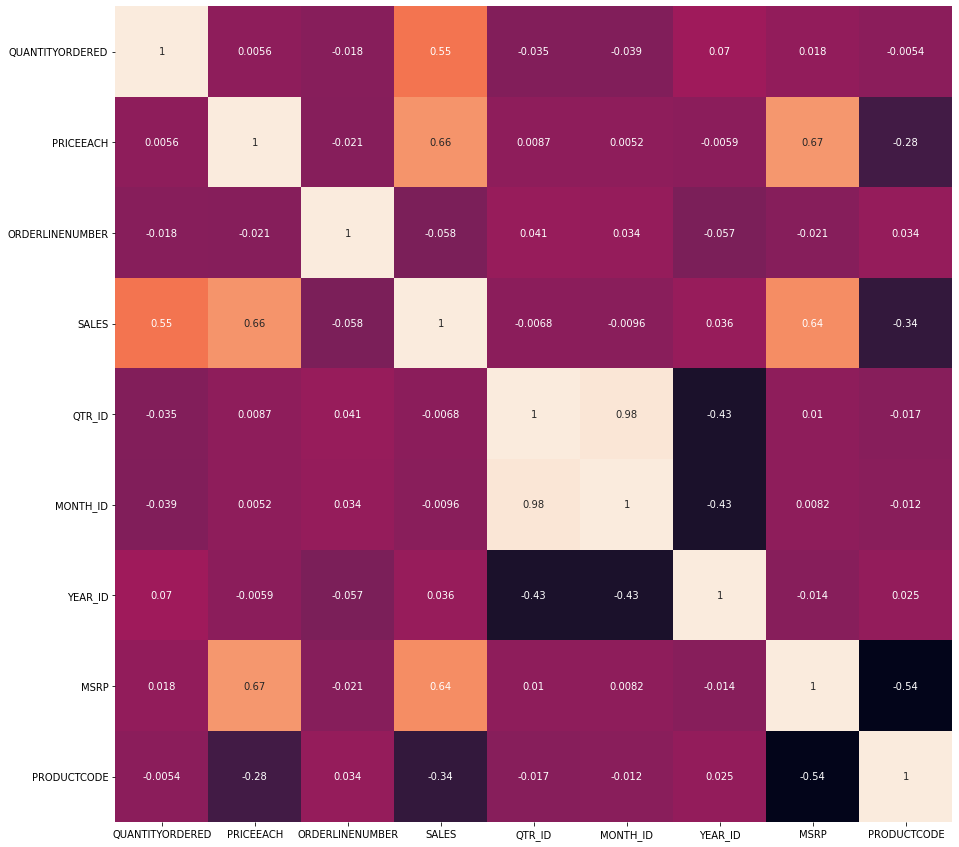

In [ ]:
plt.figure(figsize = (15, 15))
corr_matrix = sales_df.iloc[:, :9].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)

In [ ]:
# Parece que el ID del trimestre y los ID del mes están altamente correlacionados
# Dejemos 'QTR_ID' (o 'MONTH_ID')
sales_df.drop("QTR_ID", axis = 1, inplace = True)
sales_df.shape

(2823, 37)

In [ ]:
# Representar las distribuciones
# Distplot muestra el (1) histograma, (2) kde plot y (3) rug plot.
# (1) Histograma: es una visualización gráfica de datos que usa barras con varias alturas. Cada barra agrupa los números en rangos y las barras más altas muestran que hay más datos en ese rango.
# (2) Densidad: la estimación de la función de densidad se utiliza para visualizar la densidad de probabilidad de una variable continua.
# (3) Gráfico de alfombra: gráfico de datos para una única variable cuantitativa, que se muestra como marcas a lo largo de un eje (gráfico de dispersión unidimensional).

import plotly.figure_factory as ff

plt.figure(figsize = (10, 10))

for i in range(8):
  if sales_df.columns[i] != 'ORDERLINENUMBER':
    col_name = sales_df.columns[i]
    fig = ff.create_distplot([sales_df[col_name].apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text = col_name)
    fig.show()


<Figure size 720x720 with 0 Axes>

In [ ]:
# Visualizar la relación entre variables usando parcelas
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()

# Existe una tendencia entre 'SALES' y 'QUANTITYORDERED'
# Existe una tendencia entre 'MSRP' y 'PRICEEACH'
# Existe una tendencia entre 'PRICEEACH' y 'SALES'
# Parece que el crecimiento de las ventas se nota a medida que pasamos de 2013 a 2014 y a 2015 ('VENTAS' frente a 'YEAR_ID')
# Si hacemos zoom en 'VENTAS' y 'CANTIDAD ORDENADA', se puede ver la información mensual codificada por colores en el gráfico


<Figure size 1080x1080 with 0 Axes>

# ENCONTRAR EL NÚMERO ÓPTIMO DE CLUSTERS UTILIZANDO EL MÉTODO DE CODO

In [ ]:
# Escalamos los datos
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)

In [ ]:
 sales_df_scaled.shape

(2823, 37)

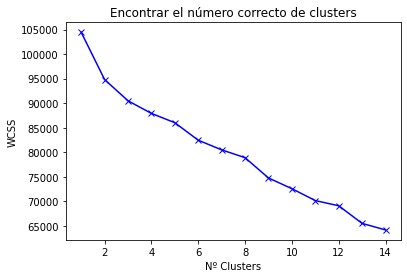

In [ ]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(sales_df_scaled)
  scores.append(kmeans.inertia_) # la inercia es la suma de los cuadrados de las distancias de las observaciones al centro del cluster más cercano

plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clusters')
plt.xlabel('Nº Clusters')
plt.ylabel('WCSS') 
plt.show()

# A partir de esto podemos observar que, el 5º grupo parece estar formando el codo de la curva.
# Tengamos en cuenta que la curva cambiará cada vez que ejecutemos la celda

# APLICAR EL MÉTODO K-MEANS

In [ ]:
# Agrupar los datos usando k-means
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_


In [ ]:
labels

array([2, 2, 1, ..., 4, 4, 4], dtype=int32)

In [ ]:
kmeans.cluster_centers_.shape

(5, 37)

In [ ]:
# Echemos un vistazo a los centros de los clústeres
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers 

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,0.013139,-0.396807,0.160159,-0.334319,0.010234,-0.032711,-0.690094,0.633095,-0.212338,-0.140961,0.253722,-0.159458,0.200603,-0.037257,-0.064628,0.027371,0.270496,-0.005445,0.056178,-0.024202,-0.096414,0.224041,0.185935,-0.051220,-0.105371,0.004266,-0.064705,-0.721812,-0.364452,-0.348674,-0.300637,5.971795,-0.345470,-0.523371,-0.186004,-0.305250,0.392101
1,0.267137,0.599614,-0.027845,0.480034,0.009476,-0.016772,0.440432,-0.275865,0.009749,0.026760,-0.026950,-0.025806,-0.021204,-0.003464,-0.008003,0.008317,-0.011610,-0.037008,-0.035928,0.010911,0.020738,-0.004888,-0.011161,-0.007157,0.063376,-0.021120,0.038543,0.170932,0.023154,-0.016977,-0.300637,-0.167454,0.107778,-0.015545,-0.242672,1.019676,-0.912100
2,-0.471508,-0.766219,0.039814,-0.825614,0.009366,0.003008,-0.577834,0.154705,0.064312,-0.023103,-0.041400,0.009312,-0.059183,-0.000058,0.020412,0.004517,-0.003169,0.054332,0.031267,0.025041,0.007796,0.005911,-0.024596,-0.014871,-0.027217,-0.005617,-0.030234,-0.073439,0.074367,0.140379,-0.300637,-0.167454,0.003461,0.185922,-0.242672,-0.980703,1.096370
3,1.246891,0.800157,-0.255984,2.571482,-0.081396,0.126876,1.446248,-0.885353,-0.083492,0.044555,-0.108756,-0.118235,0.109300,-0.003031,0.053992,0.025099,0.095281,0.024708,0.006029,0.011361,-0.029309,-0.014209,-0.037307,-0.052404,-0.105371,-0.115303,0.114070,0.588443,0.014123,-0.163096,-0.300637,-0.167454,-0.200082,-0.148900,4.120788,-0.980703,-0.912100
4,-0.037171,0.009763,0.078809,-0.271913,-0.043991,0.001642,-0.363043,1.126176,-0.230280,-0.017283,0.328593,0.225285,0.253957,0.033071,-0.068335,-0.091535,-0.075499,-0.073395,0.021919,-0.176195,-0.096414,-0.066031,0.139501,0.160278,-0.105371,0.214897,-0.118035,-0.721812,-0.364452,-0.348674,3.326275,-0.167454,-0.345470,-0.523371,-0.242672,-0.066000,0.177967


In [ ]:
# Para entender lo que significan estos números, realicemos una transformación inversa
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers

# Clúster 0 (más alto): este grupo representa a los clientes que compran artículos en una gran cantidad centrada en ~ 47, compran artículos en todos los rangos de precios inclinándose hacia artículos de alto precio de ~ 99. También corresponden a las ventas totales más altas alrededor de ~ 8296 y están activas durante todo el año. Son los mayores compradores de productos con un MSRP alto ~ 158.
# Clúster 1: este grupo representa a los clientes que compran artículos en cantidades variables ~ 35, tienden a comprar artículos de alto precio ~ 96. Sus ventas son un poco mejores en promedio ~ 4435, compran productos con el segundo MSRP más alto de ~ 133.
# Clúster 2 (más bajo): este grupo representa a los clientes que compran artículos en cantidades bajas ~ 30. Suelen comprar artículos de bajo precio ~ 68. Sus ventas ~ 2044 son más bajas que las de otros grupos y son extremadamente activos durante la temporada navideña. Compran productos con un MSRP bajo ~ 75.
# Clúster 3: este grupo representa a los clientes que solo están activos durante las vacaciones. compran en menor cantidad ~ 35, pero tienden a comprar artículos de precio promedio alrededor de ~ 86. También corresponden a ventas totales más bajas alrededor de ~ 3673, tienden a comprar artículos con MSRP alrededor de 102.
# Clúster 4: este grupo representa a los clientes que compran artículos en cantidad variable ~ 39, tienden a comprar artículos de precio promedio ~ 94. Sus ventas ~ 4280.

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,35.220779,75.654675,7.142857,2938.226883,7.129870,2003.792208,72.987013,73.766234,0.012987,-1.387779e-17,3.896104e-02,-3.122502e-17,0.051948,0.025974,0.090909,0.025974,2.597403e-02,0.038961,0.025974,2.597403e-02,-1.040834e-17,0.064935,0.181818,0.012987,-1.734723e-18,0.051948,0.324675,-2.220446e-16,8.326673e-17,-1.526557e-16,-6.938894e-17,1.000000e+00,-4.163336e-17,3.330669e-16,1.298701e-02,3.376623e-01,6.493506e-01
1,37.694644,95.753173,6.348521,4437.891103,7.127098,2003.803357,118.412470,45.061551,0.067946,2.318145e-02,8.792966e-03,2.078337e-02,0.019185,0.031974,0.108713,0.023181,4.796163e-03,0.032774,0.013589,3.197442e-02,1.119105e-02,0.027178,0.117506,0.019185,1.758593e-02,0.046363,0.374101,4.236611e-01,1.247002e-01,1.031175e-01,-1.013079e-15,-3.226586e-16,1.398881e-01,2.086331e-01,-2.775558e-17,1.000000e+00,-7.827072e-15
2,30.500452,68.203376,6.634389,2033.488027,7.126697,2003.817195,77.497738,58.658824,0.081448,1.628959e-02,7.239819e-03,2.624434e-02,0.013575,0.032579,0.117647,0.022624,5.429864e-03,0.050679,0.022624,3.438914e-02,9.954751e-03,0.028959,0.113122,0.018100,8.144796e-03,0.049774,0.341176,3.076923e-01,1.411765e-01,1.520362e-01,-3.469447e-16,-1.769418e-16,1.076923e-01,2.914027e-01,6.522560e-16,-1.054712e-15,1.000000e+00
3,47.237179,99.798269,5.384615,8289.373141,6.794872,2003.903846,158.826923,25.814103,0.044872,2.564103e-02,-2.081668e-17,6.410256e-03,0.038462,0.032051,0.128205,0.025641,1.282051e-02,0.044872,0.019231,3.205128e-02,6.410256e-03,0.025641,0.108974,0.012821,4.336809e-17,0.025641,0.410256,6.217949e-01,1.217949e-01,5.769231e-02,-1.110223e-16,-7.979728e-17,4.487179e-02,1.538462e-01,1.000000e+00,-7.771561e-16,1.054712e-15
4,34.730769,83.855470,6.799145,3053.150128,6.931624,2003.816239,86.128205,89.337607,0.008547,1.709402e-02,4.700855e-02,5.982906e-02,0.059829,0.038462,0.089744,0.008547,-1.908196e-17,0.025641,0.021368,1.075529e-16,3.642919e-17,0.017094,0.166667,0.042735,5.724587e-17,0.098291,0.299145,1.665335e-16,-4.718448e-16,-1.387779e-17,1.000000e+00,-1.318390e-16,-1.387779e-17,5.551115e-16,-1.942890e-16,4.572650e-01,5.427350e-01


In [ ]:
labels.shape # Etiquetas del clúster asociado a cada observación

(2823,)

In [ ]:
labels.max()

4

In [ ]:
labels.min()

0

In [ ]:
y_kmeans = kmeans.fit_predict(sales_df_scaled)
y_kmeans


array([1, 1, 2, ..., 2, 1, 2], dtype=int32)

In [ ]:
y_kmeans.shape

(2823,)

In [ ]:
# Agregar una etiqueta (qué clúster) correspondiente a cada punto de datos
sale_df_cluster = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2
1,34,81.35,5,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
2,41,94.74,2,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
3,45,83.26,6,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
4,49,100.00,14,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4
2819,29,100.00,1,3978.51,1,2005,54,108,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,4
2820,43,100.00,4,5417.57,3,2005,54,108,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,4
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4


In [ ]:
sales_df['ORDERLINENUMBER'] = sales_df['ORDERLINENUMBER'].apply(lambda x: float(x))

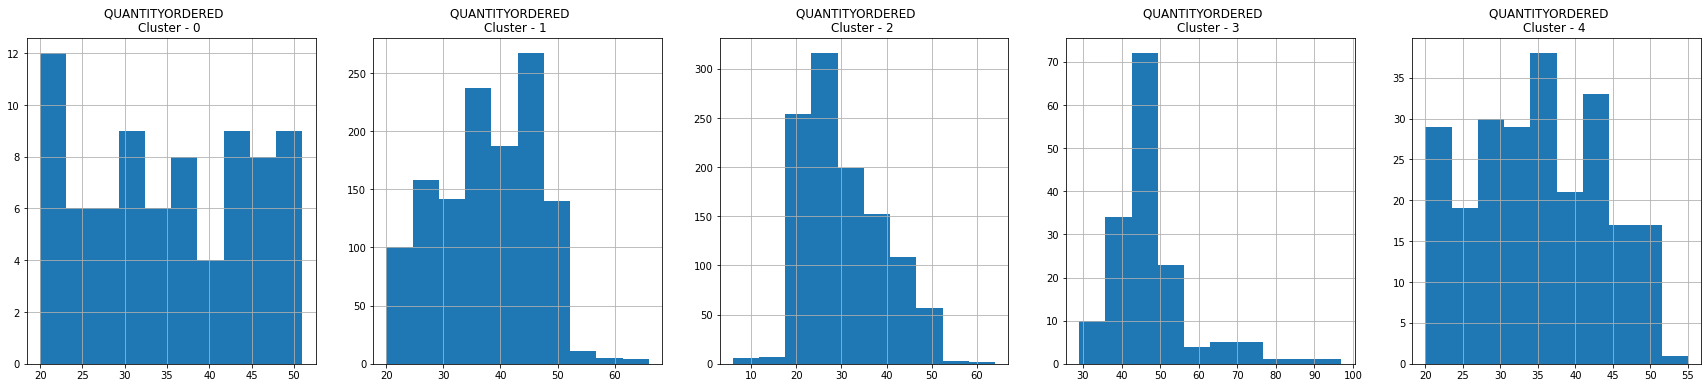

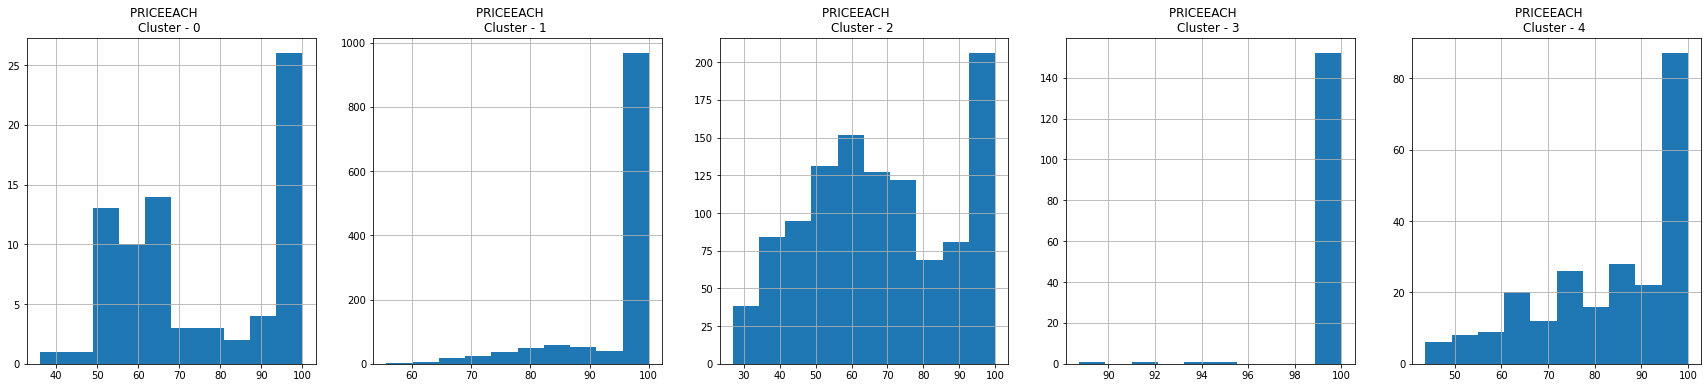

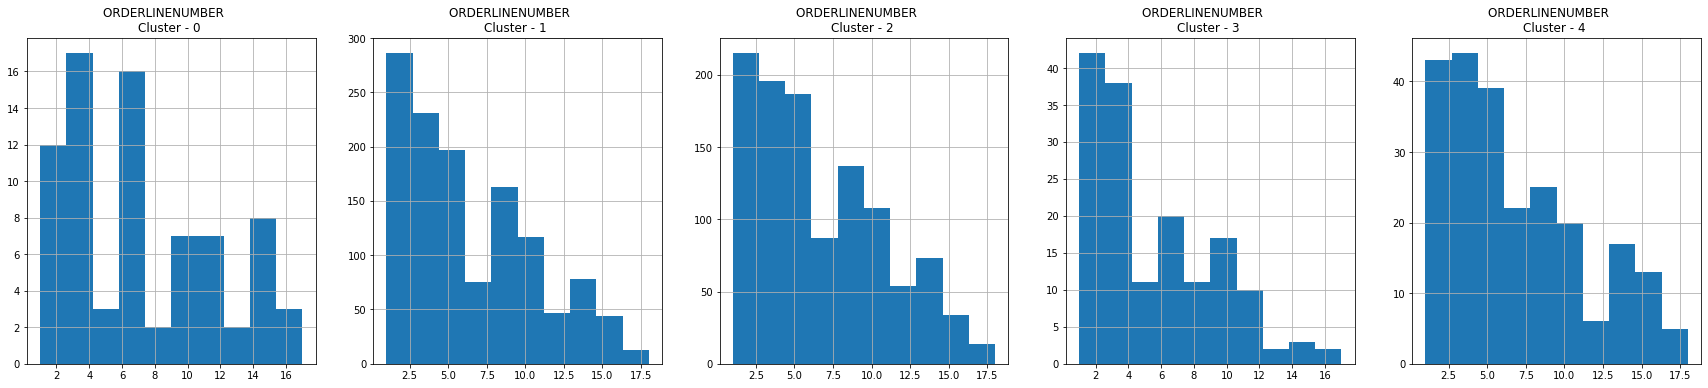

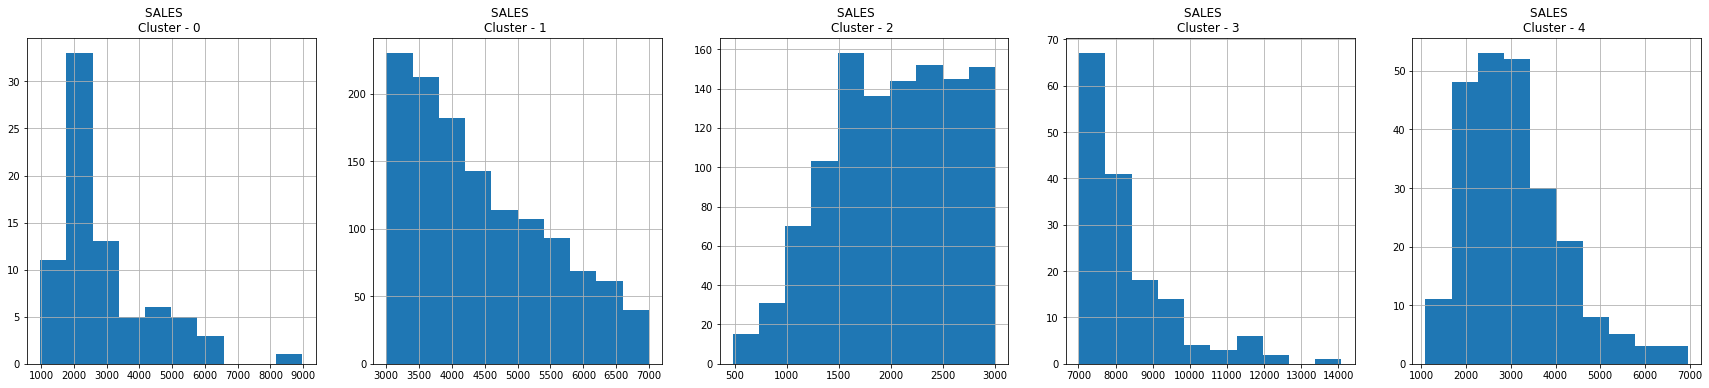

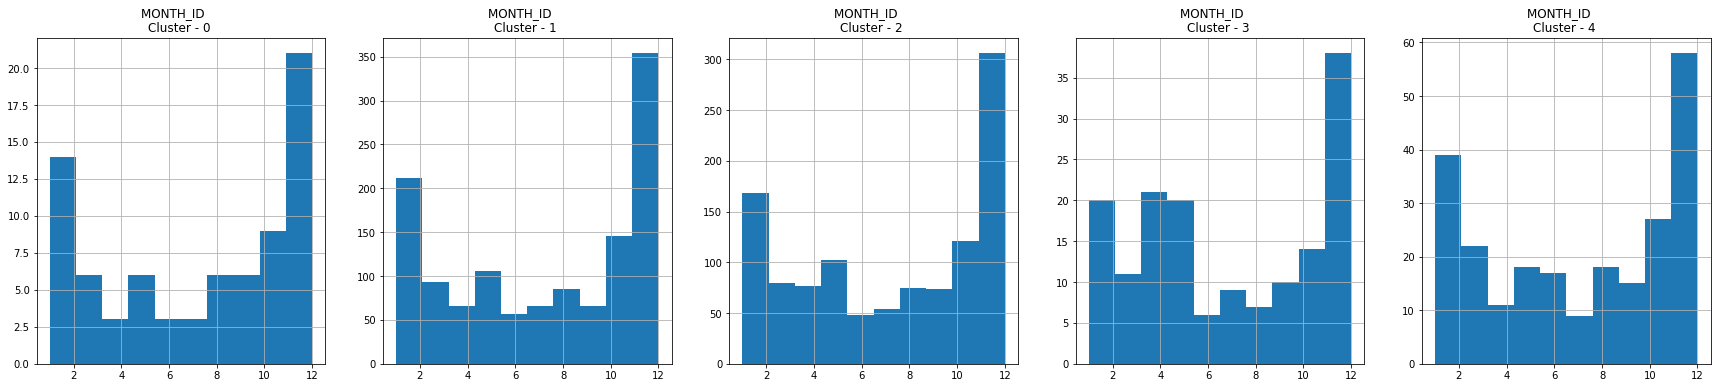

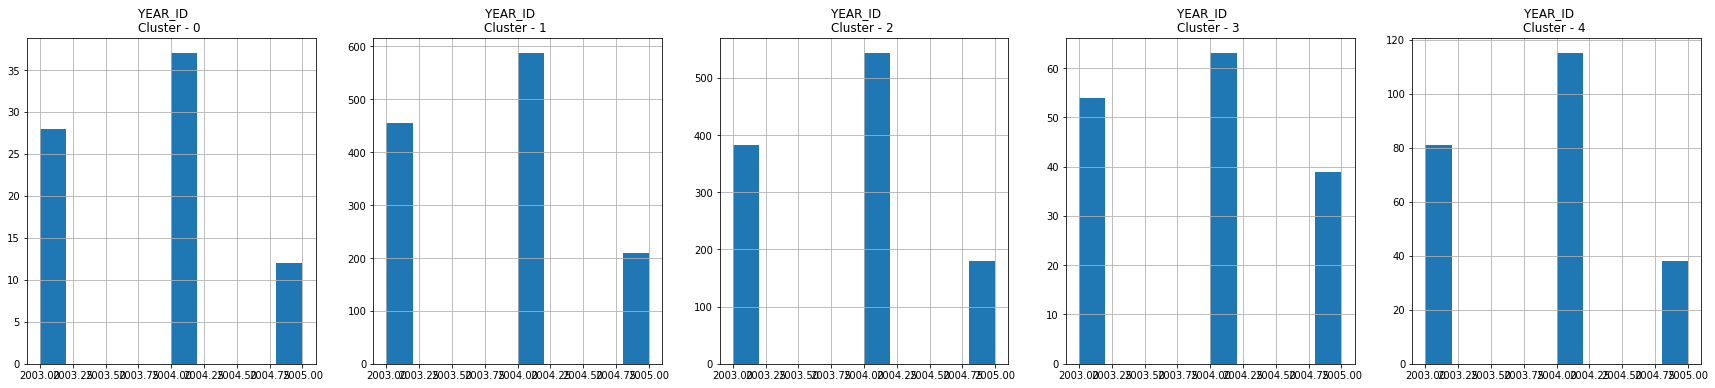

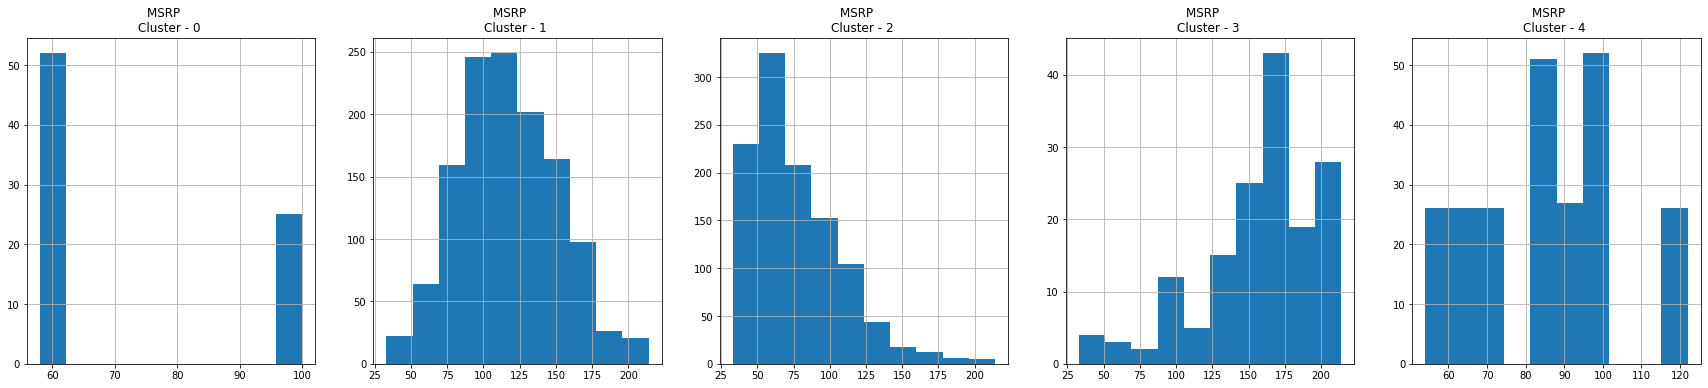

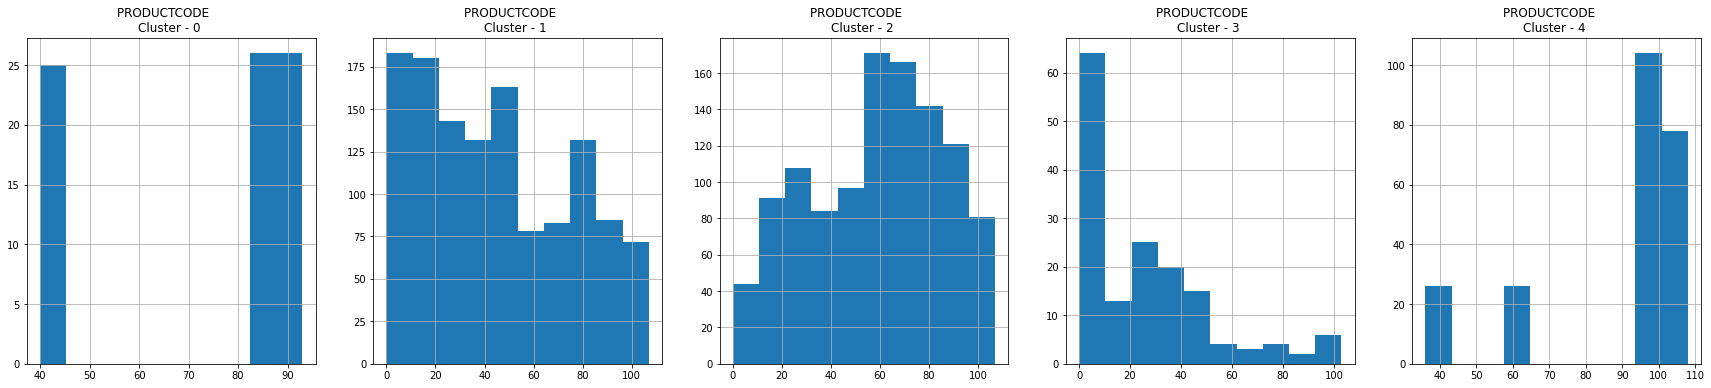

In [ ]:
# Representar un histograma para cada característica según el clúster al que pertenece
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    cluster = sale_df_cluster[sale_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()


In [ ]:
# Reducir los datos originales a 3 dimensiones usando PCA para visualizar los clústeres
pca = PCA(n_components = 3)
principal_comp = pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48638335, -1.18924267,  1.02227436],
       [-0.78471591, -1.01479687,  1.40066622],
       [ 1.43140417,  0.14186526,  0.26694042],
       ...,
       [ 0.38997192,  4.05662552, -0.11335055],
       [-2.7889184 ,  2.35317929,  1.52293978],
       [-0.7055867 ,  3.27631066, -0.52178646]])

In [ ]:
pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486383,-1.189243,1.022274
1,-0.784716,-1.014797,1.400666
2,1.431404,0.141865,0.266940
3,1.288338,-0.211897,-0.574293
4,1.975904,-0.123142,-1.062156


In [ ]:
# Concatenar las etiquetas de los clústeres al dataframe
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

,pca1,pca2,pca3,cluster
0,-0.486383,-1.189243,1.022274,2
1,-0.784716,-1.014797,1.400666,2
2,1.431404,0.141865,0.266940,1
3,1.288338,-0.211897,-0.574293,1
4,1.975904,-0.123142,-1.062156,1
...,...,...,...,...
2818,-2.450258,1.083166,-1.601567,4
2819,-0.158456,3.649761,0.618648,4
2820,0.389972,4.056626,-0.113351,4
2821,-2.788918,2.353179,1.522940,4


In [ ]:
# Visualizar los clústeres con 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3', 
              color = 'cluster', symbol = 'cluster', size_max = 18, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

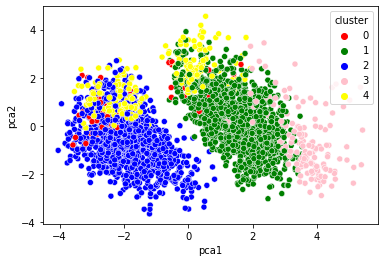

In [ ]:
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(sales_df_scaled)

pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)

ax = sns.scatterplot(x = "pca1", y = "pca2", hue = "cluster", data = pca_df, palette = ["red", "green", "blue", "pink", "yellow"])
plt.show()

# APLICAR AUTOENCODERS PARA REALIZAR LA REDUCCIÓN DE DIMENSIONALIDAD 

In [ ]:
sales_df.shape

(2823, 37)

In [ ]:
# from keras.optimizers import SGD

input_df = Input(shape = (37,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(37, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

# encoder - utilizado para reducir la dimensión
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [ ]:
autoencoder.fit(sales_df_scaled, sales_df_scaled, batch_size = 128, epochs = 500, verbose = 3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [ ]:
autoencoder.save_weights('autoencoder_1.h5')

In [ ]:
pred = encoder.predict(sales_df_scaled)

In [ ]:
pred

array([[ 0.        ,  0.9572773 ,  2.052799  , ...,  2.8538415 ,
         5.177384  ,  3.7766817 ],
       [ 0.        ,  1.474308  ,  3.2650466 , ...,  1.1344082 ,
         4.54118   ,  6.102257  ],
       [ 0.        ,  1.8946625 ,  6.611377  , ...,  1.6915857 ,
         7.6524625 ,  6.197023  ],
       ...,
       [ 0.        ,  5.2380247 ,  1.7845033 , ...,  8.191807  ,
         2.2916932 ,  4.8318996 ],
       [ 0.        ,  8.066888  ,  2.925734  , ...,  3.8033655 ,
         7.006839  , 14.542607  ],
       [ 0.        ,  5.8996243 ,  0.51634616, ...,  7.410111  ,
         4.386255  ,  3.2716434 ]], dtype=float32)

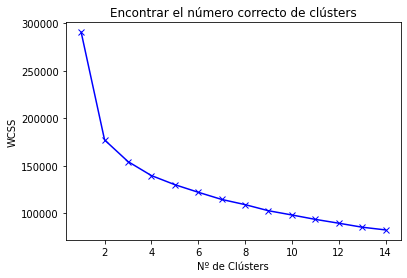

In [ ]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(pred)
  scores.append(kmeans.inertia_)

plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clústers')
plt.xlabel('Nº de Clústers')
plt.ylabel('WCSS') 
plt.show()

In [ ]:
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(sales_df_scaled)

In [ ]:
df_cluster_dr = pd.concat([sales_df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2.0,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,34,81.35,5.0,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,41,94.74,2.0,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
3,45,83.26,6.0,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,49,100.00,14.0,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers 


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,-0.084647,0.043374,-0.108756,-0.118498,0.107642,-0.004181,0.071653,0.023985,0.094193,0.023250,0.005118,0.010166,-0.029737,-0.015199,-0.039435,-0.052984,-0.105371,-0.116045,0.108611,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.91210
1,0.293073,0.580208,-0.010805,0.458608,0.003368,-0.012482,0.376634,-0.165542,-0.013717,0.010642,-0.007922,-0.006125,0.000556,0.003647,-0.011355,-0.001952,-0.017750,-0.042017,-0.024145,0.001387,0.009480,-0.003200,0.007377,0.015695,0.047160,0.001323,0.019290,0.085141,-0.014094,-0.048853,-0.020232,-0.052121,0.064221,-0.064346,-0.242672,1.019676,-0.91210
2,-0.468912,-0.724370,0.043454,-0.810304,0.007142,-0.003285,-0.581757,0.285478,0.025174,-0.016801,0.021872,0.021124,-0.013783,-0.003425,0.003484,-0.000830,0.007626,0.042513,0.025440,-0.002742,-0.006592,0.005316,-0.003135,-0.010455,-0.038008,0.012783,-0.034126,-0.162957,0.013781,0.072858,0.058660,0.071986,-0.044714,0.087993,-0.242672,-0.980703,1.09637


In [ ]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [sales_df.columns])
cluster_centers


,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,0.044586,0.025478,-1.908196e-17,0.006369,0.038217,0.031847,0.133758,0.025478,0.012739,0.044586,0.019108,0.031847,0.006369,0.025478,0.108280,0.012739,4.336809e-17,0.025478,0.407643,0.617834,0.121019,0.057325,-1.110223e-16,0.006369,0.044586,0.152866,1.000000e+00,-7.771561e-16,9.992007e-16
1,37.947254,95.361741,6.420520,4398.433699,7.104769,2003.806358,115.848988,48.545520,0.062139,0.020954,1.083815e-02,0.023844,0.022399,0.033237,0.107659,0.021676,0.004335,0.031792,0.015173,0.030347,0.010116,0.027457,0.123555,0.022399,1.589595e-02,0.051301,0.364884,0.382948,0.112717,0.093208,7.731214e-02,0.018786,0.126445,0.188584,-5.273559e-16,1.000000e+00,-8.715251e-15
2,30.525741,69.047496,6.649766,2061.682800,7.118565,2003.812793,77.340094,62.788612,0.071763,0.017161,1.404056e-02,0.028081,0.020281,0.031981,0.112324,0.021841,0.006240,0.048362,0.021841,0.029641,0.008580,0.028861,0.120125,0.018721,7.020281e-03,0.053822,0.339314,0.265211,0.121685,0.131045,9.906396e-02,0.039002,0.092824,0.251170,-1.595946e-16,-1.054712e-15,1.000000e+00


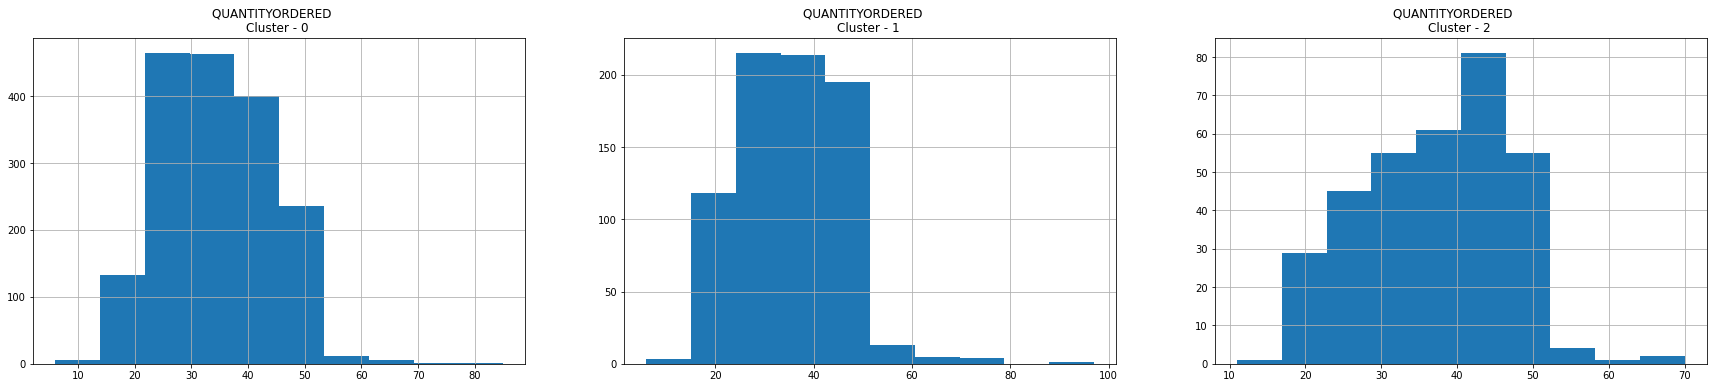

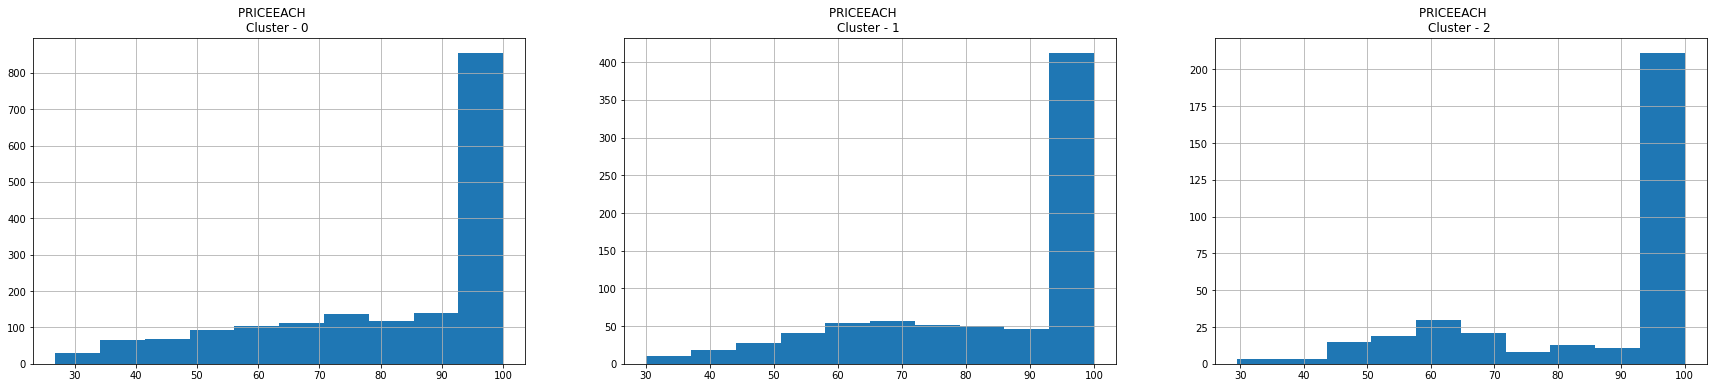

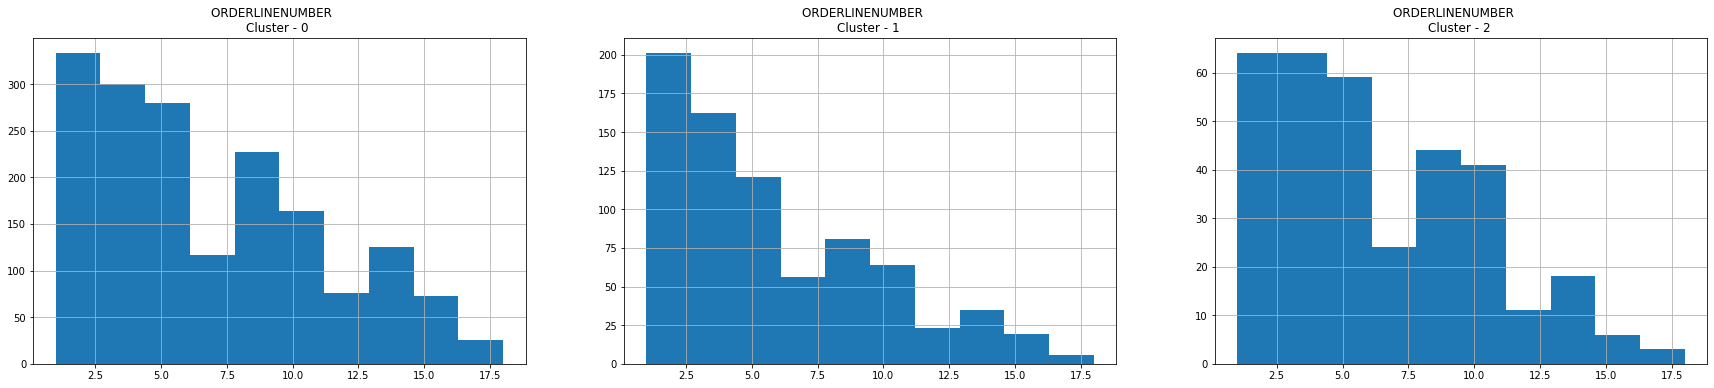

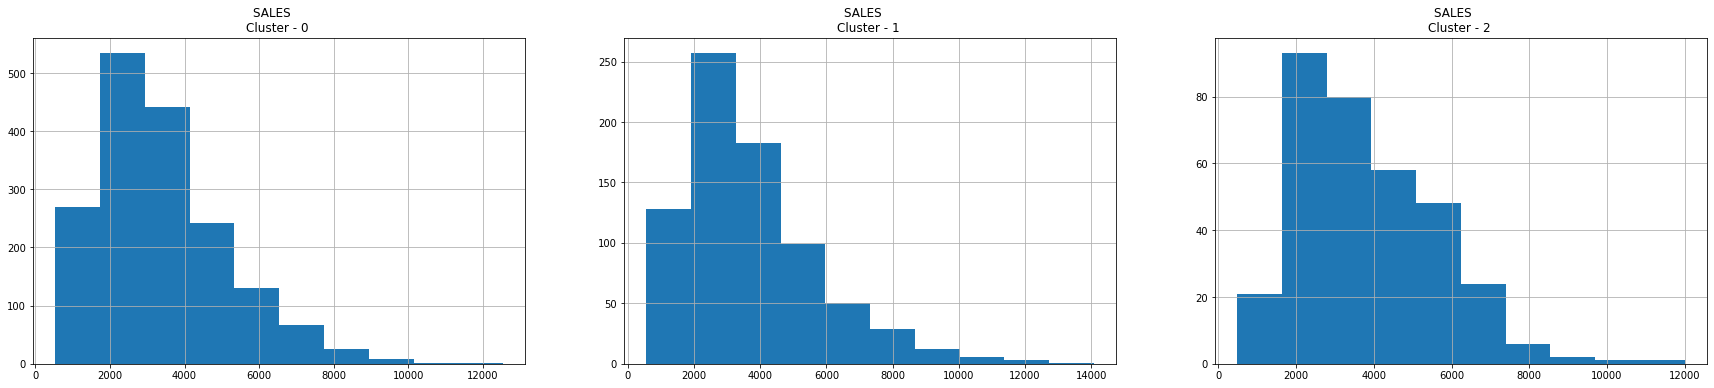

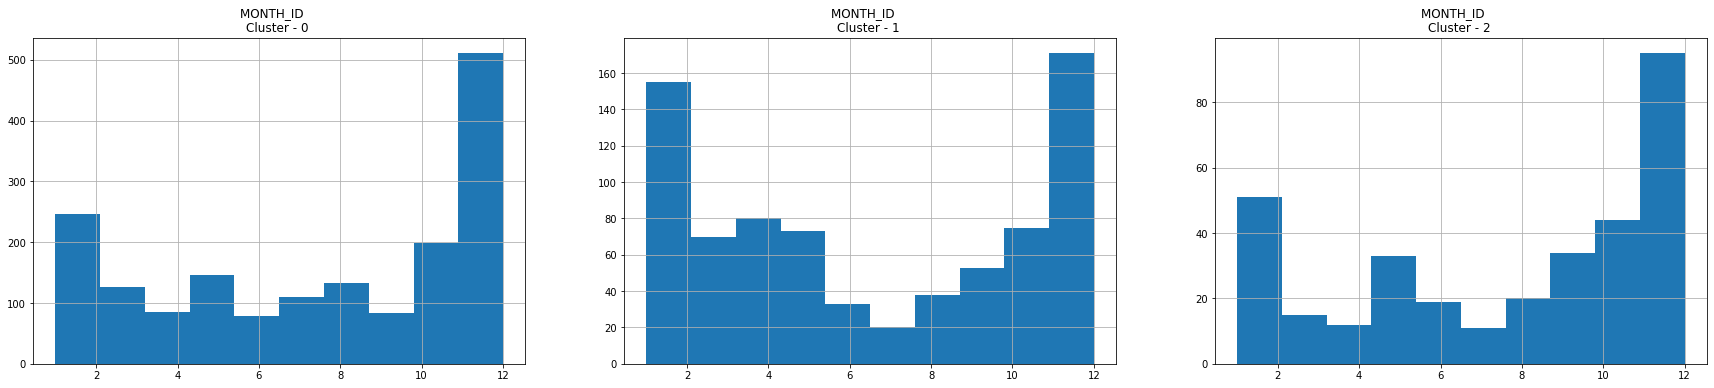

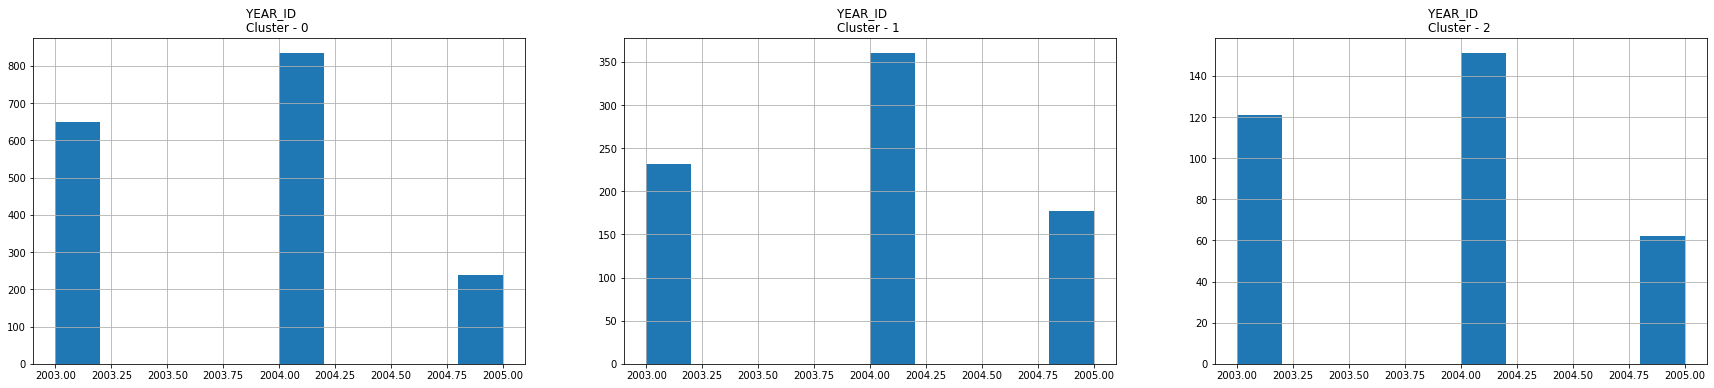

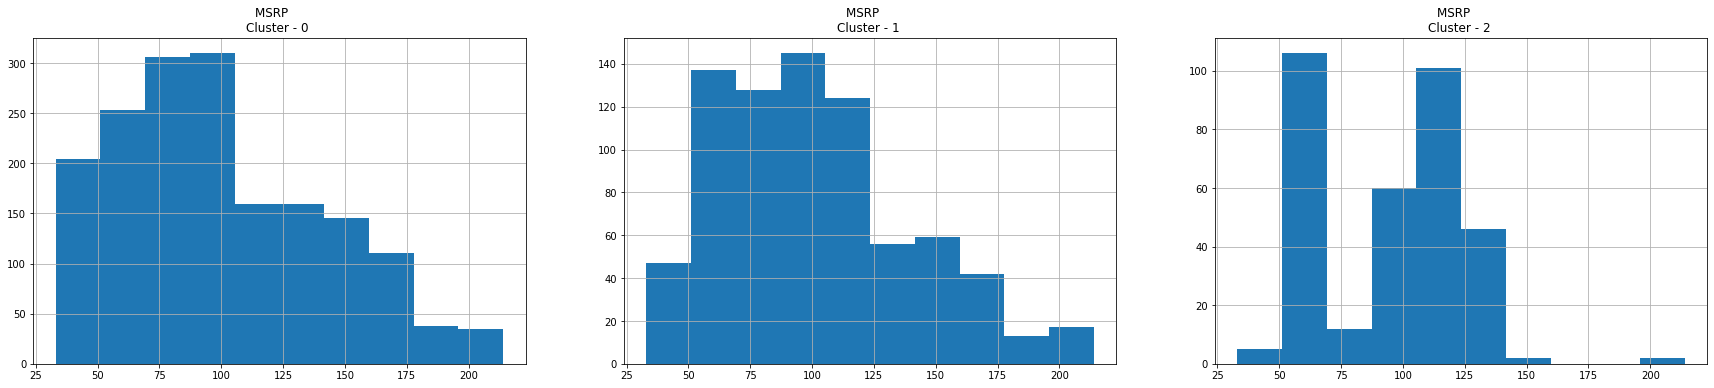

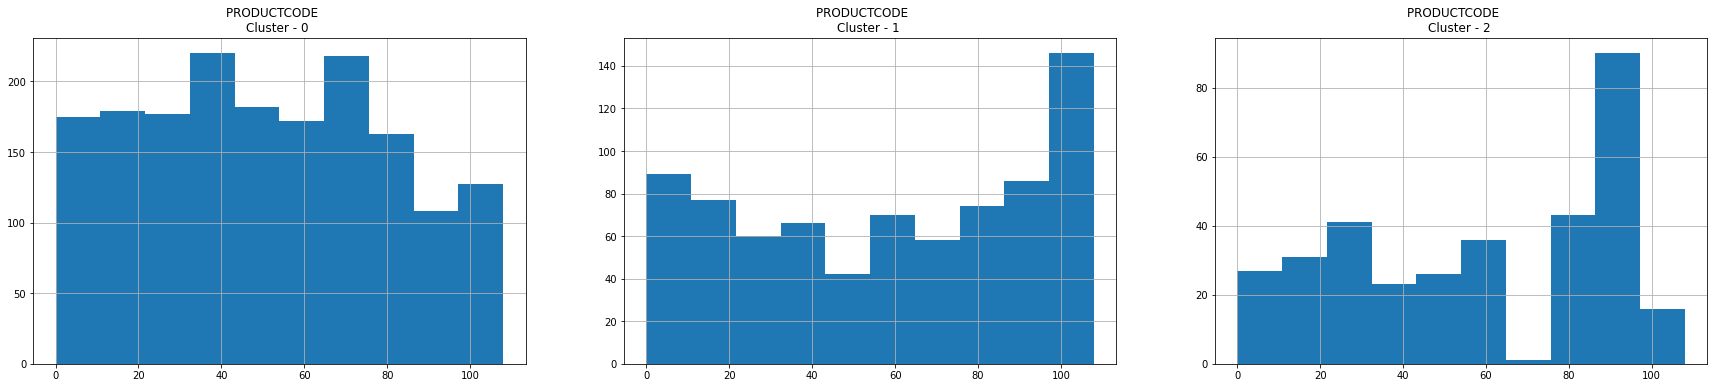

In [ ]:
# plot histogram for each feature based on cluster 
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(3):
    plt.subplot(1, 3, j+1)
    cluster = df_cluster_dr[df_cluster_dr['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()


In [ ]:
# Clúster 0: este grupo representa a los clientes que compran artículos en gran cantidad (47), por lo general compran artículos con precios altos (99). Aportan más ventas que otros grupos. En su mayoría están activos durante todo el año. Suelen comprar productos correspondientes al código de producto 10-90. Compran productos con un alto mrsp (158).
# Clúster 1: este grupo representa a los clientes que compran artículos en cantidad promedio (37) y que compran tienden a comprar artículos de precio alto (95). Aportan un promedio de ventas (4398) y están activos todo el año, son los mayores compradores de los productos correspondientes a los códigos de producto 0-10 y 90-100, además prefieren comprar productos con un PVPR elevado (115).
# Clúster 2: este grupo representa a los clientes que compran artículos en pequeñas cantidades (30), tienden a comprar artículos de bajo precio (69). Corresponden a la venta total más baja (2061) y están activos durante todo el año. Son los mayores compradores de productos correspondientes a los códigos de producto 0-20 y 100-110 y luego compran productos con PVPR bajo (77).

In [ ]:
# Reducir los datos originales a 3 dimensiones usando ACP para visualizar los clústeres
pca = PCA(n_components = 3)
prin_comp = pca.fit_transform(sales_df_scaled)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2', 'pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486343,-1.223415,1.042421
1,-0.784646,-1.007344,1.443538
2,1.431496,0.126031,0.316277
3,1.288423,-0.251310,-0.508614
4,1.975996,-0.161153,-0.973595


In [ ]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.486343,-1.223415,1.042421,0
1,-0.784646,-1.007344,1.443538,0
2,1.431496,0.126031,0.316277,1
3,1.288423,-0.251310,-0.508614,0
4,1.975996,-0.161153,-0.973595,0


In [ ]:
# Visualizar los clústers utilizando 3D-Scatterplot
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3',
              color='cluster', symbol = 'cluster', size_max = 10, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))